In [13]:
from scipy.special import erf
import numpy as np
from math import factorial, sqrt
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [14]:
# ============================================================
# Global config
# ============================================================

DATA_FILE = "t_exit_activations_icml_test.npz"

# Hermite degrees
HERMITE_EVEN = [10,6,2]
HERMITE_ODD  = [7,5,3]

In [15]:
# ============================================================
# ICML style helper (same template as before)
# ============================================================

def set_icml_style():
    """
    Rough ICML / two-column conference style.

    - Figure width ~ two columns
    - Small fonts (8pt)
    - Thin lines, light grid
    """
    plt.rcParams.update({
        "figure.figsize": (6.75, 2.5),   # ~ two-column width, short height
        "font.size": 8,
        "axes.labelsize": 8,
        "axes.titlesize": 8,
        "legend.fontsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "lines.linewidth": 1.0,
        "axes.linewidth": 0.6,
        "savefig.dpi": 300,
        "pdf.fonttype": 42,   # embed fonts (good for Illustrator / ICML)
        "ps.fonttype": 42,
        "axes.grid": False,
    })
    # Optional LaTeX rendering (only if your env supports it)
    # plt.rcParams["text.usetex"] = True

In [16]:
# ============================================================
# Part B — load and plot 3-panel ICML figure
# ============================================================

def load_t_exit_data(data_file=DATA_FILE):
    data = np.load(data_file, allow_pickle=True)
    mu_vals_loaded = data["mu_vals"]
    names = list(data["names"])
    labels = list(data["labels"])
    T = data["T"]
    return mu_vals_loaded, names, labels, T

In [17]:
def plot_one_panel_icml(data_file=DATA_FILE,
                          out_file="t_exit_one_panel_icml_test.pdf",
                          show=True):
    """
    Produce a single ICML-style figure with 3 panels:

      (a) x, erf, ReLU, sigmoid
      (b) He2, He6, He10, He14
      (c) He3, He5, He7, He9
    """
    set_icml_style()

    mu_loaded, names, labels, T = load_t_exit_data(data_file)

    fig, axes = plt.subplots(1, 1, sharey=False)

    # Panel 1: standard activations
    group1 = ["x", "relu", "erf", "sigmoid"]
    plot_group(
        axes,
        mu_loaded,
        group1,
        names,
        labels,
        T,
        #title="Standard activations",
    )

    fig.tight_layout()
    fig.savefig(out_file, bbox_inches="tight")
    print(f"[plot] Saved figure to '{out_file}'")

    if show:
        plt.show()
    else:
        plt.close(fig)

In [246]:
def plot_group(
    ax,
    mu_vals,
    group_names,
    names,
    labels,
    T,
    title=None,
    indx=0,
    numerics_dir="data_numerics_paper",
    numerics_suffix="_time_to_overlap1.npz",
    numerics_key_mu="d_values",
    numerics_key_tau="time_to_overlap",
    numerics_key_std="std_time_to_overlap",
    theory_ls="-",
    numerics_marker="s",
    numerics_ms=0.9,
    set_xtick=True,
    set_ylim=False,
    subset_mu=[0.2, 0.325],
    inset=False,
    aggregate_mu_vals=None,   # <<< NEW: pass available mu for load_aggregate
    inset_loc="upper right",
    inset_width="42%",
    inset_height="42%",
    put_dot=True
):
    # --- theory + optional numerics (unchanged) ---
    idx = {n: i for i, n in enumerate(names)}
    label_dict = {n: lab for n, lab in zip(names, labels)}
    present = [g for g in group_names if g in idx]
    colors = plt.cm.tab10(np.linspace(0, 1, len(present)))

    for color, act in zip(colors, present):
        j = idx[act]
        ax.plot(mu_vals[indx:], T[j, indx:], theory_ls, color=color, label=label_dict[act])
        #if j==3:
        #y_mu_vals_3, x_T_3 = mu_vals, T
            


        num_path = os.path.join(numerics_dir, f"{act}{numerics_suffix}")
        if os.path.isfile(num_path):
            data = np.load(num_path)
            mu_num = data[numerics_key_mu]
            tau_num = data[numerics_key_tau] / (np.log(1000))
            std_num = data[numerics_key_std]

            srt = np.argsort(mu_num)
            mu_num, tau_num, std_num = mu_num[srt], tau_num[srt], std_num[srt]

            ax.errorbar(
                mu_num, tau_num, yerr=std_num,
                fmt=numerics_marker,
                markersize=numerics_ms,
                linestyle="none",
                color=color,
                alpha=0.9,
                label=None,
                capsize=1.5,
                elinewidth=0.8,
            )

    ax.set_yscale("log")
    if set_xtick:
        ax.set_xlabel(r"$\mu$")
    if set_ylim:
        ax.set_ylim(1, 10**5)
    ax.set_ylabel(r"$\tau(\mu)$")
    ax.grid(True, linewidth=0.5, alpha=0.7)
    if title is not None:
        ax.set_title(title)
    ax.legend(frameon=True, fontsize=7, loc="upper left")

    # --- inset ---
    if inset:
        axins = inset_axes(ax, width=inset_width, height=inset_height, loc=inset_loc, borderpad=0.8)

        mu_lo, mu_hi = subset_mu
        mu_sel = [m for m in mu_vals if mu_lo <= m <= mu_hi]

        max_curves = 4
        if len(mu_sel) > max_curves:
            idxs = np.linspace(0, len(mu_sel) - 1, max_curves).astype(int)
            mu_sel = [mu_sel[k] for k in idxs]

        # If user didn't provide available aggregate mu values, fall back to mu_sel itself.
        if aggregate_mu_vals is None:
            aggregate_mu_vals = np.array(mu_sel, dtype=float)

        endf = -1
        i=0
        colors = ["purple", "#ff7f0e"]
        #mu_targets = [0.2, 0.325]
        #dot_colors = colors  # list of length 2
        if put_dot:
            for mu_t, c in zip(subset_mu, colors):
                # find closest index in mu_vals
                #y_mu_vals_3, x_T_3 = mu_vals, T
                #idx_mu = np.argmin(np.abs(y_mu_vals_3 - mu_t))
                idx_mu = np.argmin(np.abs(mu_vals - mu_t))
                y_t = T[j, idx_mu]
                # plot dot
                ax.scatter(mu_vals[idx_mu], y_t, color=c, s=10, zorder=3)
                ax.axvline(mu_t, color=c, alpha=0.3, linewidth=1)

            put_dot=False
            
        for m in subset_mu:
            # Assumes load_aggregate(mu) exists and expects a "valid" mu key
            data = load_aggregate(m)
            data_m = data["overlap_v_teacher_mean"][:endf]

            t = np.arange(len(data_m))/np.log(1000)
            axins.plot(
                t, data_m,
                "-.",
                color=colors[i],
                linewidth=1.0,
                alpha=0.95,
                label=fr"He$_3,~\mu=${m}",
            )
            i+=1

        #axins.set_title(rf"$m(t)$ for $\mu\in[{mu_lo:.2f},{mu_hi:.2f}]$", fontsize=7)
        #axins.set_title(r"He$_{3}$")
        axins.set_xscale("log")
        #axins.set_ylabel("m")
        axins.set_ylabel("m")
        axins.yaxis.set_label_coords(-0.13, 0.71)
        #axins.set_ylabel("m", labelpad=8)
        axins.set_xlabel(r"$t/\log (d)$")
        axins.xaxis.set_label_coords(0.4, -0.22)
        axins.grid(True, linewidth=0.5, alpha=0.7)
        axins.tick_params(axis="both", which="both", labelsize=7)
        axins.legend(loc="upper left")


In [247]:
def plot_one_panel_icml(data_file=DATA_FILE,
                        out_file="t_exit_one_panel_icml_test.pdf",
                        show=True):
    """
    Produce a single ICML-style figure with 1 panel:
      (a) x, erf, ReLU, sigmoid
    """
    set_icml_style()

    mu_loaded, names, labels, T = load_t_exit_data(data_file)

    # ---- control panel size here ----
    fig = plt.figure(figsize=(4.0, 3.0))  # width, height in inches (ICML-friendly)
    ax = fig.add_subplot(111)

    # Panel: standard activations
    group1 = ["x", "relu", "erf", "sigmoid"]
    plot_group(
        ax,
        mu_loaded,
        group1,
        names,
        labels,
        T,
    )

    fig.tight_layout()
    fig.savefig(out_file, bbox_inches="tight")
    print(f"[plot] Saved figure to '{out_file}'")

    if show:
        plt.show()
    else:
        plt.close(fig)

[plot] Saved figure to 't_exit_one_panel_icml_test.pdf'


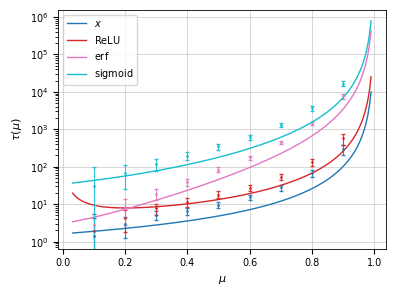

In [248]:
plot_one_panel_icml()

In [249]:
def plot_two_panels_icml(data_file=DATA_FILE,
                          out_file="t_exit_two_panels_icml_test.pdf",
                          show=True):
    """
    Produce a single ICML-style figure with 2 panels of different heights:
      (top)  Odd Hermite
      (bottom) Even Hermite (larger)
    """
    #set_icml_style_two_1()

    mu_loaded, names, labels, T = load_t_exit_data(data_file)

    # ---- figure + gridspec (key part) ----
    fig = plt.figure(figsize=(4.5, 4.8))  # total figure size
    gs = GridSpec(
        nrows=2,
        ncols=1,
        height_ratios=[0.7, 1.5],  # <-- DIFFERENT PANEL SIZES
        hspace=0.05                # vertical spacing
    )

    ax_top = fig.add_subplot(gs[0])
    ax_top.set_xticklabels([]) 
    ax_bottom = fig.add_subplot(gs[1], sharey=ax_top)

    # ---- Panel 1: odd Hermite (smaller) ----
    group2 = [f"He{d}" for d in HERMITE_EVEN]
    plot_group(
        ax_top,
        mu_loaded,
        group2,
        names,
        labels,
        T,
        set_xtick=False
    )

    # ---- Panel 2: even Hermite (larger) ----
    group1 = [f"He{d}" for d in HERMITE_ODD]
    plot_group(
        ax_bottom,
        mu_loaded,
        group1,
        names,
        labels,
        T,
        indx=3,
        set_ylim=True,
        inset=True
    )

    #set_icml_style_two_2()

    fig.savefig(out_file, bbox_inches="tight")
    print(f"[plot] Saved figure to '{out_file}'")

    if show:
        plt.show()
    else:
        plt.close(fig)

In [250]:
def snap_mu(mu, available_mu):
    """
    Snap mu to the closest value in available_mu.
    """
    available_mu = np.asarray(available_mu)
    return float(available_mu[np.argmin(np.abs(available_mu - mu))])

In [251]:
def load_aggregate(d, result_dir="data_numerics_paper/"):
    d_variants = [d, str(d)]
    try:
        d_variants.append(f"{float(d):.0e}")
    except Exception:
        pass

    for dv in d_variants:
        path = os.path.join(result_dir, f"He3_d_{dv}_aggregate.npz")
        if os.path.exists(path):
            print(f"✅ Found: {path}")
            return np.load(path)
    raise FileNotFoundError(f"No aggregate file found for d={d} in {result_dir}")

✅ Found: data_numerics_paper/He3_d_0.2_aggregate.npz
✅ Found: data_numerics_paper/He3_d_0.325_aggregate.npz
[plot] Saved figure to 't_exit_two_panels_icml_test.pdf'


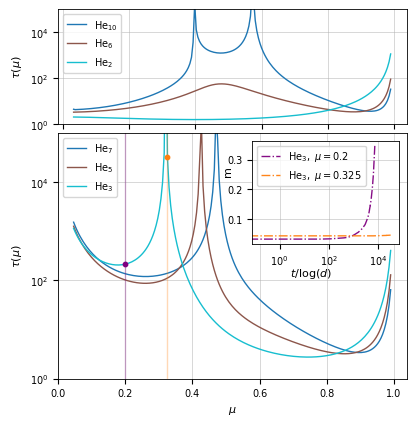

In [252]:
plot_two_panels_icml()

In [254]:
def load_t_exit_data(data_file=DATA_FILE):
    data = np.load(data_file, allow_pickle=True)
    mu_vals_loaded = data["mu_vals"]
    names = list(data["names"])
    labels = list(data["labels"])
    T = data["T"]
    teacher_square = bool(data.get("teacher_square", False))
    return mu_vals_loaded, names, labels, T, teacher_square

In [255]:
def plot_group(
    ax,
    mu_vals,
    group_names,
    names,
    labels,
    T,
    title=None,
    indx=0,
    # --- numerics overlay ---
    numerics_dir="data_numerics_paper",
    numerics_template="T_{act}S_{act}_time_to_overlap1.npz",
    numerics_key_mu="d_values",
    numerics_key_tau="time_to_overlap",
    numerics_key_std="std_time_to_overlap",
    # optional rescaling of numerics (set None to disable)
    numerics_tau_scale=1.0,          # e.g. 1.0 or 1/np.log(1000)
    # --- styling ---
    theory_ls="-",
    numerics_fmt="s",
    numerics_ms=2.0,
    numerics_alpha=0.9,
    legend_ncol=2,
    legend_fs=7,
):
    """
    Plot a subset of activations (group_names) on a given axis.

    - Theory: plots T[j, :] vs mu_vals
    - Numerics: overlays points (+ optional error bars) from
        numerics_dir / numerics_template.format(act=<mapped activation>)

      Expected .npz keys:
        - numerics_key_mu  (mu grid)
        - numerics_key_tau (tau values)
        - numerics_key_std (std / error bar) [optional]
    """

    # Map activation name -> index in T
    idx = {n: i for i, n in enumerate(names)}
    label_dict = {n: lab for n, lab in zip(names, labels)}

    # Only keep those present in theory arrays
    present = [g for g in group_names if g in idx]
    colors = plt.cm.tab10(np.linspace(0, 1, len(present)))

    # --- map internal names to filename tokens ---
    # (extend this if you later add different naming conventions)
    act_to_filetoken = {
        "x": "x",
        "relu": "relu",
        "erf": "erf",
        "sigmoid": "sigmoid",
    }

    for color, act in zip(colors, present):
        j = idx[act]
        lab = label_dict[act]

        # --------------------
        # Theory curve
        # --------------------
        y_th = T[j, :]
        ax.plot(
            mu_vals[indx:], y_th[indx:],
            theory_ls,
            color=color,
            label=lab
        )

        # --------------------
        # Numerics overlay (optional)
        # --------------------
        file_act = act_to_filetoken.get(act, act)  # default: act itself (e.g. "He2")
        num_path = os.path.join(numerics_dir, numerics_template.format(act=file_act))

        if os.path.isfile(num_path):
            data = np.load(num_path)

            # required keys
            mu_num = data[numerics_key_mu]
            tau_num = data[numerics_key_tau]/np.log(1000)

            # optional scaling
            if numerics_tau_scale is not None:
                tau_num = tau_num * numerics_tau_scale

            # optional error bars if present
            std_num = data[numerics_key_std] if numerics_key_std in data else None

            # sort by mu (safer for lines/errorbars)
            srt = np.argsort(mu_num)
            mu_num = mu_num[srt]
            tau_num = tau_num[srt]
            if std_num is not None:
                std_num = std_num[srt]

            # overlay without adding a second legend entry
            if std_num is not None:
                ax.errorbar(
                    mu_num, tau_num,
                    yerr=std_num,
                    fmt=numerics_fmt,
                    ms=numerics_ms,
                    color=color,
                    alpha=numerics_alpha,
                    elinewidth=0.7,
                    capsize=1.5,
                    label=None,
                )
            else:
                ax.plot(
                    mu_num, tau_num,
                    numerics_fmt,
                    ms=numerics_ms,
                    color=color,
                    alpha=numerics_alpha,
                    label=None,
                )

    # --------------------
    # Axis styling
    # --------------------
    ax.set_yscale("log")
    ax.grid(True, linewidth=0.5, alpha=0.7)

    if title is not None:
        ax.set_title(title, fontsize=8)

    ax.legend(frameon=False, ncol=legend_ncol, fontsize=legend_fs)

In [256]:
def load_aggregate(d, result_dir="data_numerics_paper/"):
    d_variants = [d, str(d)]
    try:
        d_variants.append(f"{float(d):.0e}")
    except Exception:
        pass

    for dv in d_variants:
        path = os.path.join(result_dir, f"He3_d_{dv}_aggregate_square.npz")
        if os.path.exists(path):
            print(f"✅ Found: {path}")
            return np.load(path)
    raise FileNotFoundError(f"No aggregate file found for d={d} in {result_dir}")

In [278]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_group(
    ax,
    mu_vals,
    group_names,
    names,
    labels,
    T,
    title=None,
    indx=0,
    # --- numerics overlay ---
    numerics_dir="data_numerics_paper",
    numerics_template="T_{act}S_{act}_time_to_overlap1.npz",
    numerics_key_mu="d_values",
    numerics_key_tau="time_to_overlap",
    numerics_key_std="std_time_to_overlap",
    # optional rescaling of numerics (set None to disable)
    numerics_tau_scale=1.0,
    # --- styling ---
    theory_ls="-",
    numerics_fmt="s",
    numerics_ms=2.0,
    numerics_alpha=0.9,
    legend_ncol=2,
    legend_fs=7,
    # --- inset ---
    inset=False,
    subset_mu=(0.2, 0.325),      # if len==2 interpreted as [mu_lo, mu_hi]; if >2, treated as explicit list
    inset_loc="upper right",
    inset_width="42%",
    inset_height="42%",
    inset_xscale="log",
    inset_max_curves=4,
    inset_label_fmt=r"$\mu={:.3g}$",
    put_dot=True
):
    """
    Plot theory curves + optional numerics overlay.
    Optionally adds a top-right inset that plots overlap dynamics loaded via:

        data = load_aggregate(mu)
        data_m = data["overlap_v_teacher_mean"][:endf]
    """

    # Map activation name -> index in T
    idx = {n: i for i, n in enumerate(names)}
    label_dict = {n: lab for n, lab in zip(names, labels)}

    present = [g for g in group_names if g in idx]
    colors = plt.cm.tab10(np.linspace(0, 1, len(present)))

    act_to_filetoken = {
        "x": "x",
        "relu": "relu",
        "erf": "erf",
        "sigmoid": "sigmoid",
    }

    for color, act in zip(colors, present):
        j = idx[act]
        lab = label_dict[act]

        # ---- Theory ----
        y_th = T[j, :]
        ax.plot(
            mu_vals[indx:], y_th[indx:],
            theory_ls,
            color=color,
            label=lab
        )

        # ---- Numerics overlay (optional) ----
        file_act = act_to_filetoken.get(act, act)
        num_path = os.path.join(numerics_dir, numerics_template.format(act=file_act))

        if os.path.isfile(num_path):
            data = np.load(num_path)

            mu_num = data[numerics_key_mu]
            tau_num = data[numerics_key_tau] / np.log(1000)

            if numerics_tau_scale is not None:
                tau_num = tau_num * numerics_tau_scale

            std_num = data[numerics_key_std] if numerics_key_std in data.files else None

            srt = np.argsort(mu_num)
            mu_num = mu_num[srt]
            tau_num = tau_num[srt]
            if std_num is not None:
                std_num = std_num[srt]

            if std_num is not None:
                ax.errorbar(
                    mu_num, tau_num,
                    yerr=std_num,
                    fmt=numerics_fmt,
                    ms=numerics_ms,
                    color=color,
                    alpha=numerics_alpha,
                    elinewidth=0.7,
                    capsize=1.5,
                    label=None,
                )
            else:
                ax.plot(
                    mu_num, tau_num,
                    numerics_fmt,
                    ms=numerics_ms,
                    color=color,
                    alpha=numerics_alpha,
                    label=None,
                )

    # ---- Axis styling ----
    ax.set_yscale("log")
    ax.grid(True, linewidth=0.5, alpha=0.7)

    if title is not None:
        ax.set_title(title, fontsize=8)

    #ax.legend(frameon=False, ncol=legend_ncol, fontsize=legend_fs)
    ax.legend(frameon=False, ncol=1, fontsize=legend_fs,loc="upper left")

    # =========================================================
    # Inset (ONLY added part, inspired by your second snippet)
    # =========================================================
    if inset:
        axins = inset_axes(
            ax,
            width=inset_width,
            height=inset_height,
            loc=inset_loc,
            borderpad=0.8,
        )

        # Decide which mu values to plot in the inset
        subset_mu = list(subset_mu)
        if len(subset_mu) == 2:
            mu_lo, mu_hi = subset_mu
            mu_sel = [m for m in mu_vals if (mu_lo <= m <= mu_hi)]
            if len(mu_sel) > inset_max_curves:
                idxs = np.linspace(0, len(mu_sel) - 1, inset_max_curves).astype(int)
                mu_sel = [mu_sel[k] for k in idxs]
        else:
            # explicit list of mu's
            mu_sel = subset_mu

        endf = -1
        i=0
        colors = ["purple", "#ff7f0e"]
        #dot_colors = colors  # list of length 2
        if put_dot:
            for mu_t, c in zip(subset_mu, colors):
                # find closest index in mu_vals
                #y_mu_vals_3, x_T_3 = mu_vals, T
                #idx_mu = np.argmin(np.abs(y_mu_vals_3 - mu_t))
                idx_mu = np.argmin(np.abs(mu_vals - mu_t))
                y_t = T[j, idx_mu]
                # plot dot
                ax.scatter(mu_vals[idx_mu], y_t, color=c, s=10, zorder=3)
                ax.axvline(mu_t, color=c, alpha=0.3, linewidth=1)
            put_dot=False
        for m in subset_mu:
            # Assumes load_aggregate(mu) exists and expects a "valid" mu key
            data = load_aggregate(m)
            data_m = data["overlap_v_teacher_mean"][:endf]

            t = np.arange(len(data_m))/np.log(1000)
            axins.plot(
                t, data_m,
                "-.",
                color=colors[i],
                linewidth=1.0,
                alpha=0.95,
                label=r"He$_3,~$"+inset_label_fmt.format(m),
            )
            i+=1

        if inset_xscale is not None:
            axins.set_xscale(inset_xscale)

        axins.set_ylabel(r"$m$", fontsize=7)
        axins.set_xlabel(r"$t/\log(d)$", fontsize=7)
        axins.xaxis.set_label_coords(0.4, -0.38)
        axins.grid(True, linewidth=0.5, alpha=0.7)
        axins.tick_params(axis="both", which="both", labelsize=7)
        axins.legend(loc="upper left", fontsize=7, frameon=False)


In [279]:
def plot_two_panel_icml(
    data_file=DATA_FILE,
    out_file="t_exit_two_panels_icml.pdf",
    show=True,
):
    """
    Two stacked ICML-style plots with different heights:
      - top: standard activations (smaller)
      - bottom: Hermite activations (larger)
      - independent y-axes
      - grid everywhere
    """

    #set_icml_style()

    mu_vals, names, labels, T, teacher_square = load_t_exit_data(data_file)

    # ------------------------------------------------------
    # Figure + GridSpec (KEY PART)
    # ------------------------------------------------------
    fig = plt.figure(figsize=(4.5, 4.5))  # ICML single-column width
    gs = GridSpec(
        nrows=2,
        ncols=1,
        height_ratios=[1.0, 1.5],  # <-- different subplot heights
        hspace=0.05
    )

    ax_top = fig.add_subplot(gs[0])
    ax_bottom = fig.add_subplot(gs[1])

    # ------------------------------------------------------
    # PANEL 1 — standard activations (smaller)
    # ------------------------------------------------------
    plot_group(
        ax_top,
        mu_vals,
        ["x", "erf", "relu", "sigmoid"],
        names,
        labels,
        T,
    )

    ax_top.set_xticks(np.linspace(0, 1, 8))
    ax_top.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    ax_top.set_xticklabels([])   # hide tick labels
    ax_top.set_xlabel("")
    ax_top.set_ylabel(r"$\tau(\mu)$")

    # ------------------------------------------------------
    # PANEL 2 — Hermite activations (larger)
    # ------------------------------------------------------
    plot_group(
        ax_bottom,
        mu_vals,
        ["He2", "He3", "He5"],
        names,
        labels,
        T,
        inset=True
    )

    ax_bottom.set_xticks(np.linspace(0, 1, 8))
    ax_bottom.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax_bottom.set_xlabel(r"$\mu$")
    ax_bottom.set_ylabel(r"$\tau(\mu)$")

    # ------------------------------------------------------
    # Save
    # ------------------------------------------------------
    fig.savefig(out_file, bbox_inches="tight")
    print(f"[plot] Saved figure to '{out_file}'")

    if show:
        plt.show()
    else:
        plt.close(fig)

✅ Found: data_numerics_paper/He3_d_0.2_aggregate_square.npz
✅ Found: data_numerics_paper/He3_d_0.325_aggregate_square.npz
[plot] Saved figure to 't_exit_sqteacher_icml_test_logd.pdf'


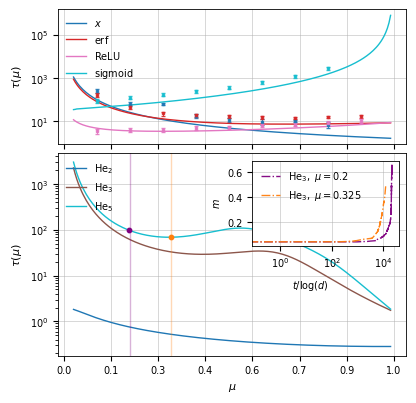

In [280]:
plot_two_panel_icml(
    data_file="t_exit_sqteacher.npz",
    out_file="t_exit_sqteacher_icml_test_logd.pdf",
)